# House Price Prediction (Regression)
> **Important note on the Boston dataset**  
> The original Boston Housing dataset is deprecated in scikit‑learn due to ethical considerations and is no longer shipped.  
> This notebook‑style script will **try** to load it from **OpenML** (requires internet). If that fails, it will fall back to the
> **California Housing** dataset that comes with scikit‑learn. The workflow and learning goals are identical.
# **Objectives**
- Build a clean preprocessing pipeline with **feature scaling** (numeric) and **one‑hot encoding** (categorical)
- Train and compare **Linear Regression** vs **Random Forest Regressor**
- Evaluate with **MAE, MSE, RMSE, R²**
- Visualize: **correlation heatmap**, **predicted vs. actual**, **residuals**, **feature importances**



In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For Boston via OpenML (may require internet)
from sklearn.datasets import fetch_openml, fetch_california_housing



ModuleNotFoundError: No module named 'numpy'

## 1) Load Dataset (Boston preferred, California fallback)


In [ ]:
use_boston = True
try:
    # Try Boston from OpenML (requires internet)
    boston = fetch_openml(name="boston", version=1, as_frame=True)
    df = boston.frame.copy()
    # Boston target column is "MEDV"
    df.rename(columns={"MEDV": "Target_MedHouseVal"}, inplace=True)
    print("Loaded Boston Housing from OpenML.")
except Exception as e:
    print("Boston load failed or unavailable. Falling back to California Housing.")
    print("Reason:", e)
    use_boston = False
    cal = fetch_california_housing(as_frame=True)
    df = cal.frame.copy()
    # California target column is "MedHouseVal"
    df.rename(columns={"MedHouseVal": "Target_MedHouseVal"}, inplace=True)

print("Shape:", df.shape)
df.head()


Boston load failed or unavailable. Falling back to California Housing.
Reason: HTTP Error 404: Not Found
Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target_MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2) Feature Engineering & Preprocessing
If the dataset is all‑numeric (e.g., California), we create categorical **bands** to demonstrate one‑hot encoding:
- `LatBand`, `LonBand`, `AgeBand` (quartile bins)
For Boston, we proceed with available features (mostly numeric). You can also create bins (e.g., for AGE) if desired.


In [ ]:
DATA = df.copy()

# Add quartile bands if columns exist (they exist in California; Boston does not have Latitude/Longitude)
if "Latitude" in DATA.columns and "Longitude" in DATA.columns:
    # Age band: use HouseAge if present, else try AGE (Boston feature)
    if "HouseAge" in DATA.columns:
        DATA["AgeBand"] = pd.qcut(DATA["HouseAge"], 4, labels=["Age_Q1","Age_Q2","Age_Q3","Age_Q4"])
    elif "AGE" in DATA.columns:
        DATA["AgeBand"] = pd.qcut(DATA["AGE"], 4, labels=["Age_Q1","Age_Q2","Age_Q3","Age_Q4"])
    # Lat/Lon bands
    DATA["LatBand"] = pd.qcut(DATA["Latitude"], 4, labels=["Lat_Q1","Lat_Q2","Lat_Q3","Lat_Q4"])
    DATA["LonBand"] = pd.qcut(DATA["Longitude"], 4, labels=["Lon_Q1","Lon_Q2","Lon_Q3","Lon_Q4"])

X = DATA.drop(columns=["Target_MedHouseVal"])  # features
y = DATA["Target_MedHouseVal"]                 # target

# Identify categorical vs numeric
categorical_cols = [c for c in X.columns if str(X[c].dtype) in ("object", "category")]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", categorical_cols)

# ColumnTransformer pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)


Numeric columns: 8
Categorical columns: ['AgeBand', 'LatBand', 'LonBand']


## 3) Train/Test Split & Model Definitions


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg = Pipeline(steps=[("preprocess", preprocessor),
                        ("model", LinearRegression())])

rf = Pipeline(steps=[("preprocess", preprocessor),
                    ("model", RandomForestRegressor(
                        n_estimators=300,
                        random_state=42,
                        n_jobs=-1
                    ))])

# Fit models
linreg.fit(X_train, y_train)
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude', 'Longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['AgeBand', 'LatBand',
                                                   'LonBand'])])),
                ('model',
                 RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42))])

## 4) Evaluation (MAE, MSE, RMSE, R²) + Cross‑Validation


In [ ]:

def evaluate(model, X_tr, y_tr, X_te, y_te, name="Model"):
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    metrics = {
        "Model": name,
        "MAE (train)": mean_absolute_error(y_tr, pred_tr),
        "MAE (test)": mean_absolute_error(y_te, pred_te),
        "MSE (test)": mean_squared_error(y_te, pred_te),
        "RMSE (test)": mean_squared_error(y_te, pred_te) ** 0.5,
        "R2 (train)": r2_score(y_tr, pred_tr),
        "R2 (test)": r2_score(y_te, pred_te),
    }
    return metrics, pred_te

lin_metrics, lin_pred = evaluate(linreg, X_train, y_train, X_test, y_test, "Linear Regression")
rf_metrics, rf_pred = evaluate(rf, X_train, y_train, X_test, y_test, "Random Forest")

results_df = pd.DataFrame([lin_metrics, rf_metrics]).round(4)
print("\nModel Performance Summary:\n", results_df)

# Cross‑Validation (R²)
cv_lin = cross_val_score(linreg, X, y, cv=5, scoring="r2", n_jobs=-1)
cv_rf = cross_val_score(rf, X, y, cv=5, scoring="r2", n_jobs=-1)
cv_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "CV R2 (mean)": [cv_lin.mean(), cv_rf.mean()],
    "CV R2 (std)": [cv_lin.std(), cv_rf.std()]
}).round(4)
print("\nCross‑Validation (R², 5‑fold):\n", cv_df)



Model Performance Summary:
                Model  MAE (train)  MAE (test)  MSE (test)  RMSE (test)  \
0  Linear Regression       0.5159      0.5221      0.5336       0.7305   
1      Random Forest       0.1204      0.3251      0.2510       0.5010   

   R2 (train)  R2 (test)  
0      0.6278     0.5928  
1      0.9744     0.8085  

Cross‑Validation (R², 5‑fold):
                Model  CV R2 (mean)  CV R2 (std)
0  Linear Regression        0.5276       0.0589
1      Random Forest        0.6485       0.0865


## 5) Visualizations (matplotlib only)
One chart per figure, no custom colors/styles.


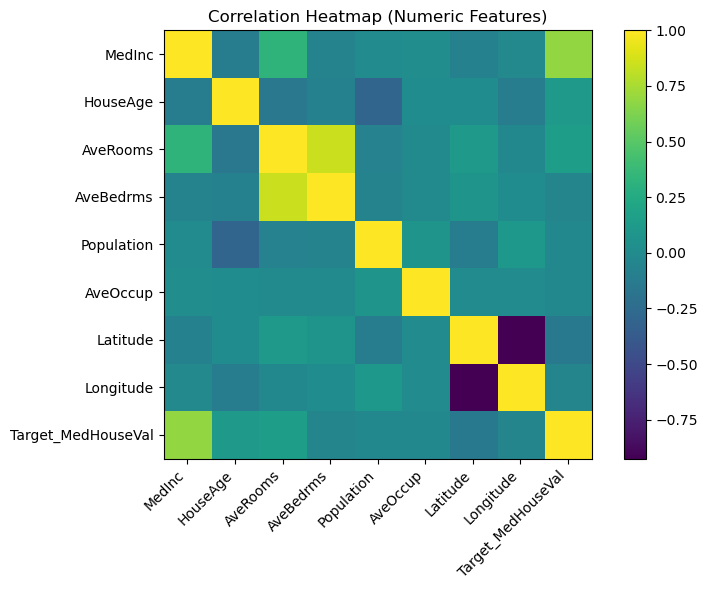

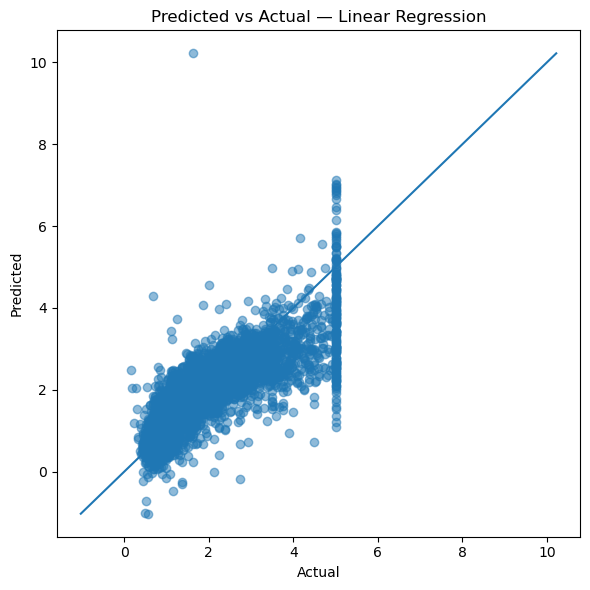

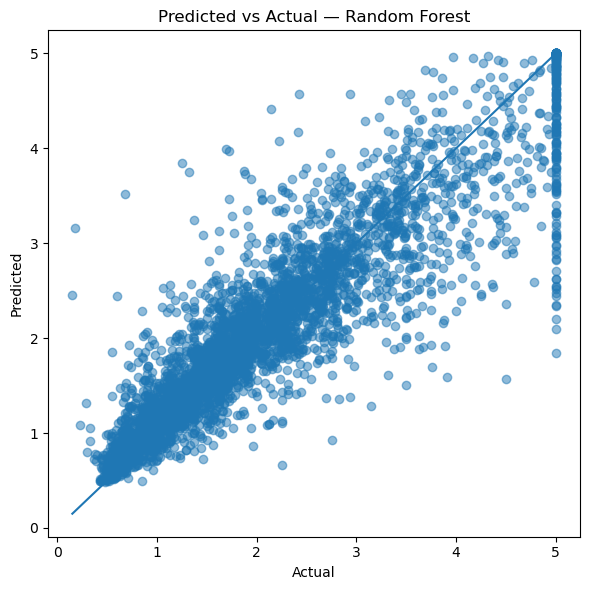

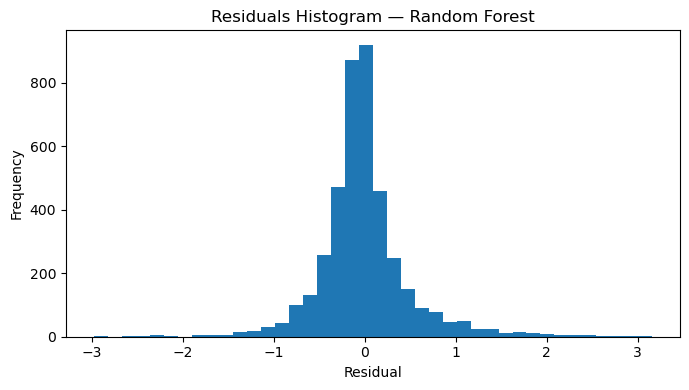


Top 15 Feature Importances — Random Forest
           Feature  Importance
0           MedInc    0.525176
1         AveOccup    0.136203
2         Latitude    0.081088
3        Longitude    0.078406
4         HouseAge    0.050359
5         AveRooms    0.042846
6       Population    0.029685
7        AveBedrms    0.028343
8   LonBand_Lon_Q3    0.008982
9   LonBand_Lon_Q2    0.007383
10  LatBand_Lat_Q2    0.002698
11  LatBand_Lat_Q3    0.001771
12  AgeBand_Age_Q2    0.001475
13  AgeBand_Age_Q3    0.001170
14  AgeBand_Age_Q1    0.001056


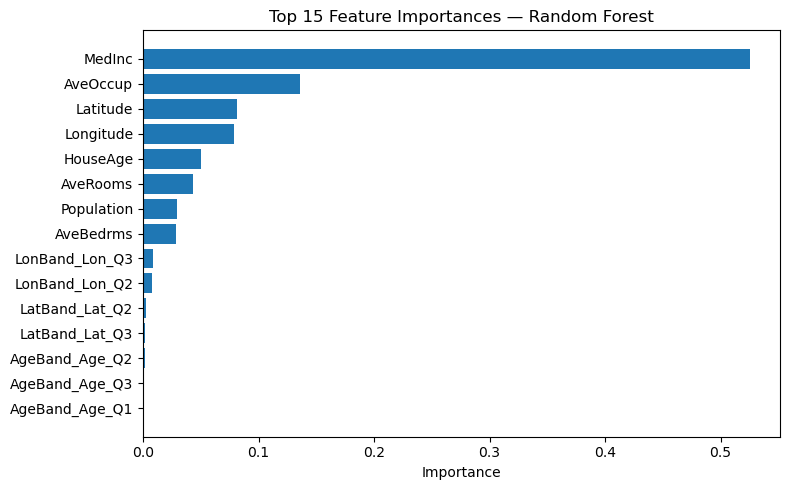

In [ ]:
# 5.1 Correlation Heatmap (numeric features only)
num_only = [c for c in X.columns if c not in categorical_cols]
heat_df = df[num_only + ["Target_MedHouseVal"]].copy()
corr = heat_df.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap (Numeric Features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

# %%
# 5.2 Predicted vs Actual — Linear Regression
plt.figure(figsize=(6,6))
plt.scatter(y_test, lin_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual — Linear Regression")
lims = [min(y_test.min(), lin_pred.min()), max(y_test.max(), lin_pred.max())]
plt.plot(lims, lims)
plt.tight_layout()
plt.show()

# %%
# 5.3 Predicted vs Actual — Random Forest
plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual — Random Forest")
lims = [min(y_test.min(), rf_pred.min()), max(y_test.max(), rf_pred.max())]
plt.plot(lims, lims)
plt.tight_layout()
plt.show()

# %%
# 5.4 Residuals Histogram — Best Model
best_name = "Random Forest" if rf_metrics["R2 (test)"] > lin_metrics["R2 (test)"] else "Linear Regression"
best_pred = rf_pred if best_name == "Random Forest" else lin_pred

residuals = y_test - best_pred
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=40)
plt.title(f"Residuals Histogram — {best_name}")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# %%
# 5.5 Feature Importances — Random Forest
preprocessor_fitted = rf.named_steps["preprocess"]

# Get transformed feature names
num_features = preprocessor_fitted.named_transformers_["num"].get_feature_names_out(numeric_cols)
if len(categorical_cols) > 0:
    cat_features = preprocessor_fitted.named_transformers_["cat"].get_feature_names_out(categorical_cols)
    all_features = np.concatenate([num_features, cat_features])
else:
    all_features = num_features

rf_model = rf.named_steps["model"]
importances = rf_model.feature_importances_

idx = np.argsort(importances)[::-1][:15]
top_features = all_features[idx]
top_importances = importances[idx]

# Table
print("\nTop 15 Feature Importances — Random Forest")
print(pd.DataFrame({"Feature": top_features, "Importance": top_importances}))

# Plot
plt.figure(figsize=(8,5))
plt.barh(range(len(top_features)), top_importances[::-1])
plt.yticks(range(len(top_features)), top_features[::-1])
plt.title("Top 15 Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



## 6) Conclusions
- Random Forest typically delivers higher test R² than Linear Regression due to nonlinearities and interactions.
- A consistent preprocessing pipeline avoids data leakage and ensures reproducibility.
- Next steps: hyperparameter tuning (RandomizedSearchCV), polynomial features for Linear Regression, and trying Gradient Boosting/XGBoost.
